In [21]:
#   This software component is licensed by ST under BSD-3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#             https://opensource.org/licenses/BSD-3-Clause

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/STMicroelectronics/stm32ai/blob/master/AI_resources/VISION/transfer_learning/TransferLearning.ipynb)

# Transfer Learning on MobileNet

This notebook shows the process of training a deep learning model via transfer learning on a custom dataset as well as the quantization of this model in order to use it on a STM32 thanks to [STM32Cube.AI](https://www.st.com/en/embedded-software/x-cube-ai.html).

This notebook is related to this ST Wiki [article](https://wiki.st.com/stm32mcu/wiki/AI:How_to_use_transfer_learning_to_perform_image_classification_on_STM32) about transfer learning.

## Import the dataset

The dataset is a directory containing one sub-directory per category, with images inside. For instance: 
```
Dataset
    ├── cats
    │   ├── cat0001.jpg
    │   ├── cat0002.jpg
    │   └── ...
    ├── dogs
    └── horses
```
If you're using this in notebook in Colab, you should import your dataset a `Dataset.zip` file and a `Testset.zip`. It will be extracted later on. Also on Colab, make sure you choose the GPU runtime for faster training.

You can also choose to use a dataset from the Tensorflow dataset repository.

## Import necessary packages
Imgaug needs to be manualy imported to ensure the usage of the latest version.

In [22]:
!pip install imgaug --upgrade

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.metrics as sk_metrics
import seaborn as sns
import pathlib

from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import datasets
from random import randint
import tensorflow_datasets as tfds

## Model selection
You can choose between a MobileNet V1 and V2.

In [24]:
MODEL_VERSION = 'V2' #@param ["V1", "V2"]
IMG_SIZE = [128, 128]
IMG_SIZE_TUPLE = (IMG_SIZE[0], IMG_SIZE[1])
BATCH_SIZE = 16

## Dataset selection
Chose a dataset from the tensorflow dataset zoo or select `custom` to use your own dataset, if you do, you must also provide a test dataset.

In [25]:
DATASET_NAME = 'tf_flowers' #@param ["custom", "tf_flowers", "uc_merced", "rock_paper_scissors", "imagenette/full-size", "horses_or_humans"]

If you chose a custom dataset, uncomment those lines to extract them. Alternatively, you can uncomment the two `wget` commands to download a pasta dataset from github

In [26]:
# !wget "https://github.com/STMicroelectronics/stm32ai/blob/master/AI_resources/VISION/transfer_learning/Dataset.zip?raw=true" -O Dataset.zip
# !wget "https://github.com/STMicroelectronics/stm32ai/blob/master/AI_resources/VISION/transfer_learning/Testset.zip?raw=true" -O Testset.zip
# !unzip -q Dataset.zip
# !unzip -q Testset.zip

## Dataset import

In [27]:
if DATASET_NAME == 'custom':
  dataset = image_dataset_from_directory('Dataset',
          shuffle=True,
          batch_size=BATCH_SIZE,
          image_size=IMG_SIZE, 
          interpolation='nearest',
          label_mode='categorical' # yields "one-hot" vectors for output
          )

  test_set = image_dataset_from_directory('Testset',
          shuffle=False,
          batch_size=BATCH_SIZE,
          image_size=IMG_SIZE, 
          interpolation='nearest',
          label_mode='categorical'
          )
  class_names = dataset.class_names
  class_number = len(class_names)
  nbr_batches = tf.data.experimental.cardinality(dataset)
  # We take 20% for validation
  validation_dataset = dataset.take(nbr_batches // 5)
  train_dataset = dataset.skip(nbr_batches // 5)
else:
  (train_dataset, validation_dataset, test_set), dataset_info = tfds.load(
            DATASET_NAME,
            split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'],
            with_info=True,
            as_supervised=True,
            shuffle_files= True
        )
  class_number = dataset_info.features['label'].num_classes
  class_names = dataset_info.features['label'].names

  # Cast data images to 8 bits and use one hot for labels 
  def prepare_data(image, label):
    image = tf.cast(tf.image.resize(image, IMG_SIZE_TUPLE), tf.uint8)
    label = tf.one_hot(label, class_number)
    return image, label


  train_dataset = train_dataset.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
  validation_dataset = validation_dataset.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
  test_set = test_set.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

## Data visualization

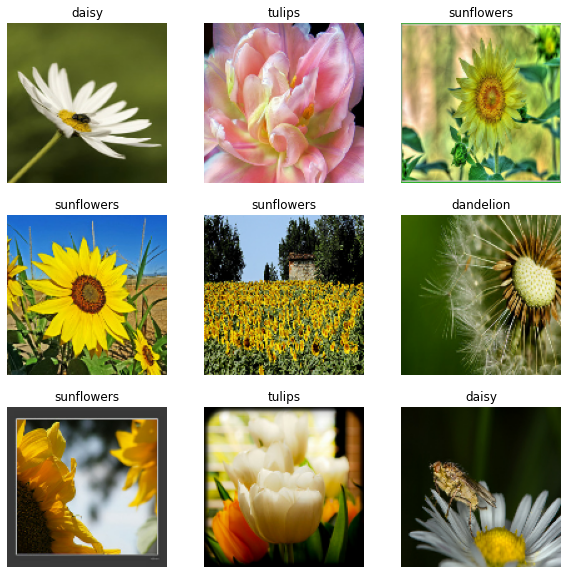

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i])]) 
        plt.axis('off')

## Augment the data for training set
We use `imgaug` library for a fine control on our data augmentation.

In [29]:
augmenter = iaa.Sequential([
    iaa.Sometimes(0.3, iaa.MotionBlur((3, 4)), name='SometimesMotionBlur'),
    iaa.Sometimes(0.3, iaa.GaussianBlur((0.0, 0.75)), name='SometimesGaussianBlur'),
    iaa.GammaContrast((0.7, 1.5)),
    iaa.MultiplySaturation((0.9, 1.5)),
    iaa.MultiplyAndAddToBrightness(),
    iaa.Fliplr(p=0.5),
    iaa.Affine(scale=(1, 1.3),
              translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},
              rotate=(-25, 25) )
])
def augmentation_function(images, labels):
    img_dtype = images.dtype
    img_shape = tf.shape(images)
    images = tf.numpy_function(augmenter.augment_images,
                                [images],
                                img_dtype)
    images = tf.reshape(images, shape=img_shape)
    return images, labels

Vizualize the different data augmentation steps.

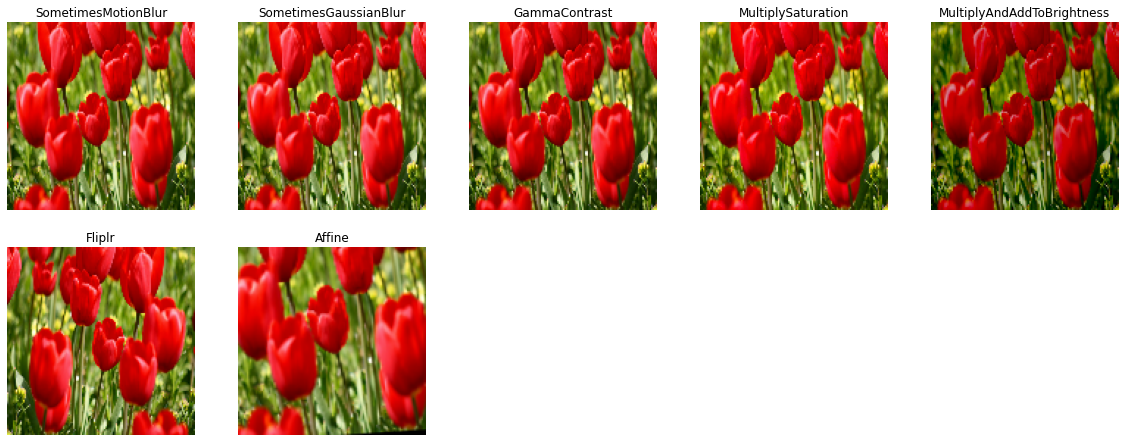

In [30]:
# Run this cell several times to see the effect of different data augmentation
image, _ = next(iter(train_dataset.unbatch().batch(1)))
plt.figure(figsize=(20, 20))
img_dtype = image.dtype
for i, augment in enumerate(augmenter):
  ax = plt.subplot(5, 5, i + 1)
  augmented_image = tf.numpy_function(augment.augment_images,
                                      [image],
                                      img_dtype)
  ax.set_title(augment.name.replace('Unnamed', ''))
  plt.imshow(augmented_image[0])
  plt.axis('off')
  

Apply the data augmentation to the whole database.

In [31]:
train_dataset = train_dataset.map(augmentation_function, num_parallel_calls=tf.data.AUTOTUNE)

Run this cell several times to see the effect of the entire data augmentation pipeline.


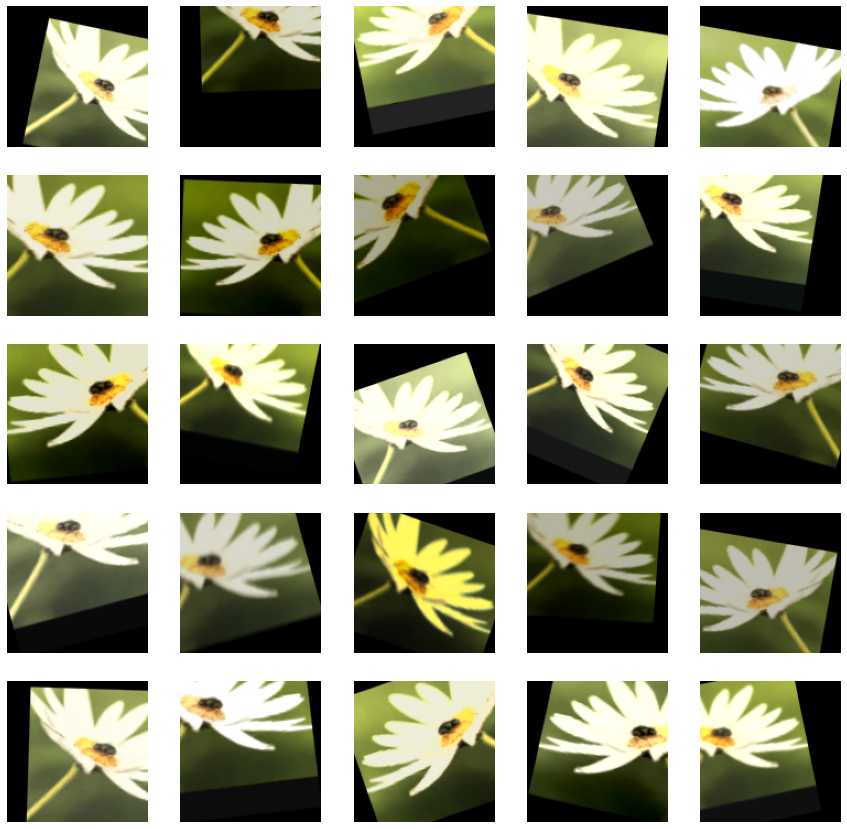

In [32]:
# Run this cell several times to see the effect on different data
image, _ = next(iter(train_dataset.unbatch().batch(1)))
plt.figure(figsize=(15, 15))
img_dtype = image.dtype
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  augmented_image = tf.numpy_function(augmenter.augment_images,
                                      [image],
                                      img_dtype)
  plt.imshow(augmented_image[0])
  plt.axis('off')

## Normalize the data before training

In [33]:
IMG_SHAPE = IMG_SIZE_TUPLE + (3,)
if MODEL_VERSION == "V1":
    normalization = tf.keras.applications.mobilenet.preprocess_input
    base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                                  alpha=0.25,
                                                  include_top=False,
                                                  weights="imagenet")
elif MODEL_VERSION == "V2":
    normalization = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                                                alpha=0.35,
                                                                include_top=False,
                                                                weights='imagenet')
else:
    print('Bad model_version argument, are only accepted : "V1", "V2"')

In [34]:
train_dataset = train_dataset.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model instantiation

In [35]:
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(class_number, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_0.35_128 (Funct  (None, 4, 4, 1280)       410208    
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 416,613
Trainable params: 6,405
Non-trainable p

## Train the model

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_dataset,
                        epochs=100,
                        validation_data=validation_dataset, callbacks=callback)

Epoch 1/5
161/161 [==============================] - 54s 293ms/step - loss: 0.9050 - accuracy: 0.6462 - val_loss: 0.5252 - val_accuracy: 0.8025
Epoch 2/5
161/161 [==============================] - 29s 182ms/step - loss: 0.6433 - accuracy: 0.7649 - val_loss: 0.4656 - val_accuracy: 0.8365
Epoch 3/5
161/161 [==============================] - 33s 206ms/step - loss: 0.5503 - accuracy: 0.7851 - val_loss: 0.4573 - val_accuracy: 0.8406
Epoch 4/5
161/161 [==============================] - 29s 182ms/step - loss: 0.5184 - accuracy: 0.8089 - val_loss: 0.4446 - val_accuracy: 0.8447
Epoch 5/5
161/161 [==============================] - 30s 183ms/step - loss: 0.5045 - accuracy: 0.8143 - val_loss: 0.4433 - val_accuracy: 0.8597


Text(0.5, 0, 'epoch')

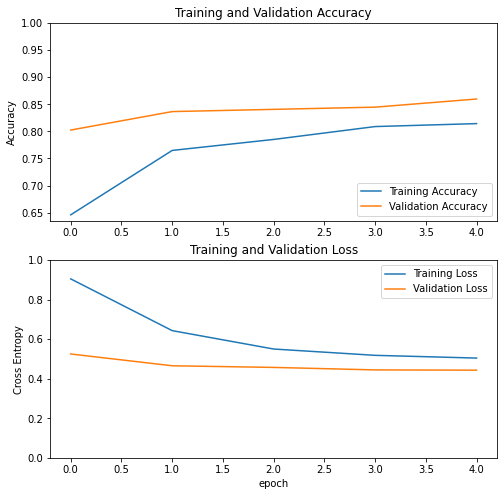

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

## Test the model

Evaluate on test data
23/23 [==============================] - 3s 111ms/step - loss: 0.3371 - accuracy: 0.8747
test loss: 0.33714690804481506, test acc: 0.8746594190597534


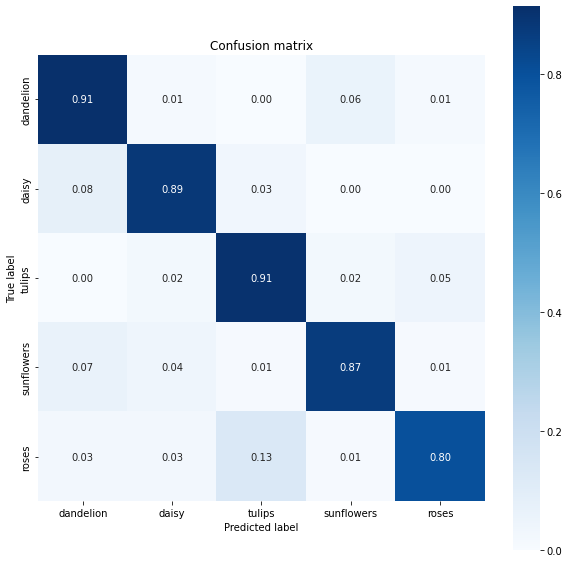

In [38]:
test_set = test_set.cache()
print("Evaluate on test data")
results = model.evaluate(test_set)
print(f"test loss: {results[0]}, test acc: {results[1]}")
predictions = model.predict(test_set)
predictions = tf.argmax(predictions, axis=1)

true_categories = tf.argmax( np.concatenate([y for x, y in test_set], axis=0), axis=1)

confusion = sk_metrics.confusion_matrix(true_categories, predictions)
confusion_normalized = [element/sum(row) for element, row in zip([row for row in confusion], confusion)]
axis_labels = list(class_names)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels, cmap='Blues',
                  annot=True,
                  fmt='.2f', square=True)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label");

## Missclassified samples

In [39]:
misclassified_images = []
misclassified_category = []
misclassified_prediction = []
for (image, true_category), prediction in zip(test_set.unbatch(), predictions):
  true_category = tf.argmax(true_category)
  if true_category != prediction:
    misclassified_images.append(image.numpy())
    misclassified_category.append(true_category)
    misclassified_prediction.append(prediction)
print('Number of misclassified images : ', len(misclassified_images))

Number of misclassified images :  46


This cell show a random sample of misclassified images.
Run this cell multiple times to view multiples missclassified samples.

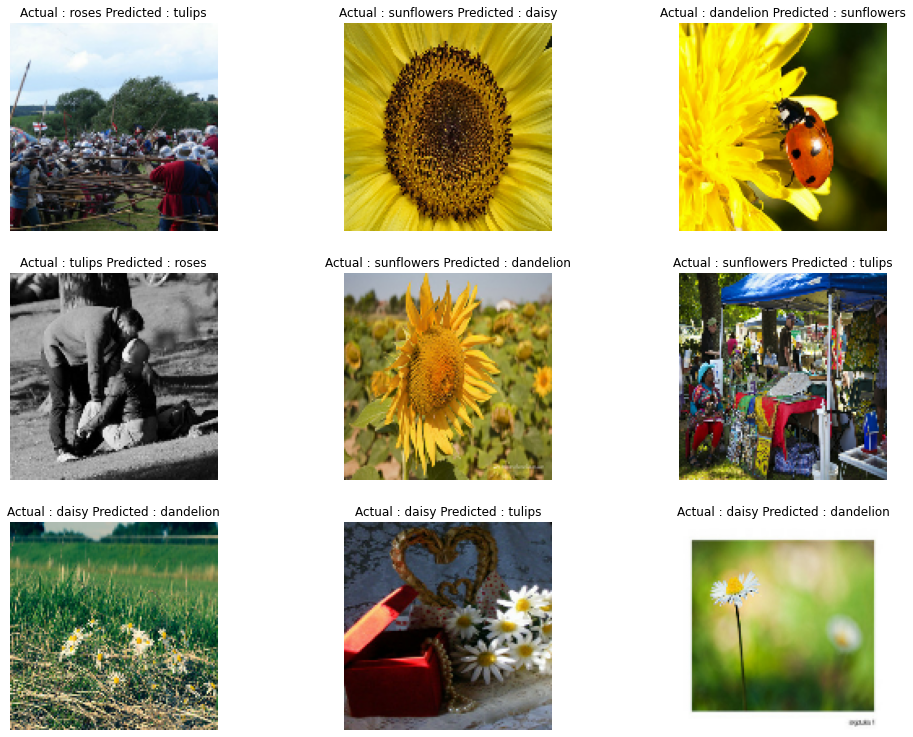

In [40]:
if len(misclassified_images) >= 9 :
  plt.figure(figsize=(17, 13))
  random_index_shift = randint(0, len(misclassified_images) - 9)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    title = 'Actual : ' + class_names[misclassified_category[random_index_shift + i]] + \
            ' Predicted : ' + class_names[misclassified_prediction[random_index_shift + i]]
    ax.set_title(title)
    plt.imshow((misclassified_images[random_index_shift + i] + 1.0) / 2.0)
    plt.axis('off')

## Quantize and export 

This cell will quantize the model and output a `model_quant.tflite` file that you can use with Cube.AI.

In [41]:
def representative_data_gen():
  for x, y in validation_dataset.take(100):
    yield [x]

# Needed for quantization in case of unfrozen MobileNet model
model.trainable = False
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

import pathlib
tflite_model_quant = converter.convert()
tflite_model_quant_file = pathlib.Path("./model_quant.tflite")
tflite_model_quant_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpprynwxi2/assets


INFO:tensorflow:Assets written to: /tmp/tmpprynwxi2/assets


630568

### Testing the quantized model
This cell test the model after quantization to check if there is any loss of performance.
The loss should be minimal, in the magnitude of a couple of percents for the accuracy.

In [42]:
# Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=str("./model_quant.tflite"))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

quant_correct_predictions = 0
quant_incorrect_predictions = 0

for (image, true_category) in test_set.unbatch():
  test_image = image
  test_label = tf.argmax(true_category)

  # Check if the input type is quantized, then rescale input data to uint8
  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details["quantization"]
    test_image = test_image / input_scale + input_zero_point

  test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
  interpreter.set_tensor(input_details["index"], test_image)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details["index"])[0]
  if(output.argmax() == test_label):
    quant_correct_predictions += 1
  else:
    quant_incorrect_predictions += 1
print(f'Accuracy : {quant_correct_predictions / (quant_correct_predictions + quant_incorrect_predictions)}')

Accuracy : 0.8637602179836512
